# Data Wrangling - Billboard Hot 100 & Spotify Track Data

## 1.0 Data Collection

### 1.1 Imports

In [1]:
import pandas as pd
import datetime as datetime
import billboard
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from fuzzywuzzy import fuzz
import os
import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### 1.2 Pull Billboard Hot 100 Data

In [2]:
#Pull key Billboard data for x number_of_weeks - includes rank, song, artist, peak position and number of weeks on the list

#Dictate the number of weeks data is required for
number_of_weeks = 78
billboard_data = {}

base = datetime.datetime(2021, 8, 28).date()
dates_list = [str(base - datetime.timedelta(days=x*7)) for x in range(number_of_weeks)]

for date in dates_list:
    chart = billboard.ChartData('hot-100', date=date, fetch=True, timeout=25)

    song_dict = {chart[i].rank: [chart[i].title, chart[i].artist, chart[i].peakPos, \
                                 chart[i].lastPos, chart[i].weeks] for i in range(100)}
    billboard_data[date] = song_dict

chart_data = pd.DataFrame.from_dict(billboard_data)

#chart_data

### 1.3 Clean Billboard Hot 100 DataFrame

In [3]:
chart_data = chart_data.reset_index().rename(columns={"index": "Rank"})

chart_data = pd.melt(chart_data, id_vars = ['Rank'], var_name = ['Date'])
chart_data[['BB_Title','BB_Artist','PeakPos', 'LastPos', 'Weeks']] = \
        pd.DataFrame(chart_data['value'].tolist(), index= chart_data.index)

chart_data = chart_data.drop(columns=['value'])

chart_data

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19
...,...,...,...,...,...,...,...
7795,96,2020-03-07,Ridin' Roads,Dustin Lynch,47,85,17
7796,97,2020-03-07,Me And My Guitar,A Boogie Wit da Hoodie,58,58,2
7797,98,2020-03-07,Feel Me,Selena Gomez,98,0,1
7798,99,2020-03-07,Vete,Bad Bunny,33,96,13


### 1.4 Isolate Unique Songs From Hot 100 DataFrame

In [4]:
unique_songs = chart_data.drop_duplicates(subset = ['BB_Title', 'BB_Artist']).reset_index(drop=True)

unique_songs

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19
...,...,...,...,...,...,...,...
1089,89,2020-03-07,Bat Man,YoungBoy Never Broke Again,89,0,1
1090,93,2020-03-07,Shake The Room,Pop Smoke Featuring Quavo,93,0,1
1091,94,2020-03-07,Rare,Selena Gomez,30,90,7
1092,97,2020-03-07,Me And My Guitar,A Boogie Wit da Hoodie,58,58,2


### 1.5 Find Unique Songs in Spotify

In [5]:
cid = '67d7ec42ddd4497887d1d28bcf66d607'
secret = '0ae4cd8474934b0fa2705ce70a47fd3d'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [6]:
#test code for reviewing sp.search and sp.artist outputs
#track_test_search = sp.search(q='track:STAY artist:The Kid', type='track', limit=1, market='US')
#artist_test_search = sp.artist(artist_id=track_test_search['tracks']['items'][0]['artists'][0]['id'])['genres']

#track_test_search
#artist_test_search

In [7]:
def mod_value(value, char_list, trunc = False):
    """ Takes the value and a list of unnecessary characters,
    removes them and truncates the string"""
    
    new_value = value
    for char in char_list:
        new_value = new_value.replace(char,"")
    
    if trunc == True:
        new_value = new_value.split()[0]

    return new_value

In [8]:
def song_data(title, artist):
    '''Searches Spotify for song title in Billboard Hot 100 list, returns the 
    top 2 searches and finds the highest match ratio between artist. 
    Returns highest match ratio title, artist and song id'''
    
    #removing feat., "X", etc. from artist and title   
    mod_artist = mod_value(artist, [' X','& ','Featuring ',' x', '(',')',' +'], trunc = True)
    mod_title = mod_value(title, ["'"])
    
    song = []
    highest_ratio = 0
    track_results = sp.search(q='track:'+mod_title+' artist:'+mod_artist, type='track', limit=2, market='US')
    
    for i, t in enumerate(track_results['tracks']['items']):
        match_ratio = fuzz.partial_ratio(mod_artist.lower(), t['artists'][0]['name'].lower())
        if match_ratio > highest_ratio:
            highest_ratio = match_ratio
            song = []
            song.extend([t['name'], t['artists'][0]['name'], highest_ratio, t['id']])
            
            genres = sp.artist(t['artists'][0]['id'])['genres']
            song.append(genres)
    return song

In [9]:
unique_songs['SP_Data'] = unique_songs.apply(lambda row: song_data(row['BB_Title'],row['BB_Artist']),axis=1)

unique_songs[['SP_Title','SP_Artist', 'Match_Ratio','SP_id','Genres']] = pd.DataFrame(unique_songs.SP_Data.tolist(), \
                                                                    index= unique_songs.index)

unique_songs = unique_songs.drop(columns=['SP_Data'])

unique_songs

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,SP_id,Genres
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,5HCyWlXZPP0y6Gqq8TgA20,[australian hip hop]
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8,Bad Habits,Ed Sheeran,100.0,6PQ88X9TkUIAUIZJHW2upE,"[pop, uk pop]"
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14,good 4 u,Olivia Rodrigo,100.0,4ZtFanR9U6ndgddUvNcjcG,[pop]
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1,Rumors (feat. Cardi B),Lizzo,100.0,6KgtcmCF9Ky68XC7ezxl3s,"[dance pop, escape room, minnesota hip hop, po..."
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19,Kiss Me More (feat. SZA),Doja Cat,100.0,748mdHapucXQri7IAO8yFK,"[dance pop, pop]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1089,89,2020-03-07,Bat Man,YoungBoy Never Broke Again,89,0,1,Bat Man,YoungBoy Never Broke Again,100.0,6fEdWrEYspdneQMNIT33I4,"[baton rouge rap, trap]"
1090,93,2020-03-07,Shake The Room,Pop Smoke Featuring Quavo,93,0,1,Shake The Room (feat. Quavo),Pop Smoke,100.0,7rSnKi58HPIVC0FVyh04Q1,[brooklyn drill]
1091,94,2020-03-07,Rare,Selena Gomez,30,90,7,Rare,Selena Gomez,100.0,3eFzNuGkjSDshjigBpKYti,"[dance pop, pop, post-teen pop]"
1092,97,2020-03-07,Me And My Guitar,A Boogie Wit da Hoodie,58,58,2,Me and My Guitar,A Boogie Wit da Hoodie,100.0,6cZH4rX1KTt1aJ3Ql6Ynja,"[melodic rap, pop rap, rap, trap]"


### 1.6 Get Song Attributes from Spotify

In [10]:
def song_atts(sp_id):
    '''Uses SP_id to find Spotify song attributes''' 
    song_attributes = {}
    
    if sp_id != None:
        att_results = sp.audio_features(tracks=sp_id)
        song_attributes = att_results[0] 
    return song_attributes

In [11]:
unique_songs['SP_Atts'] = unique_songs.apply(lambda row: song_atts(row['SP_id']),axis=1)

unique_songs = pd.concat([unique_songs.drop(['SP_Atts'], axis=1), unique_songs['SP_Atts'].apply(pd.Series)], axis=1)\
                    .drop(columns=['type','id','uri', 'track_href','analysis_url'])

unique_songs

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,...,-5.484,1.0,0.0483,0.0383,0.000000,0.1030,0.478,169.928,141806.0,4.0
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8,Bad Habits,Ed Sheeran,100.0,...,-3.712,0.0,0.0348,0.0469,0.000031,0.3640,0.591,126.026,231041.0,4.0
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14,good 4 u,Olivia Rodrigo,100.0,...,-5.044,1.0,0.1540,0.3350,0.000000,0.0849,0.688,166.928,178147.0,4.0
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1,Rumors (feat. Cardi B),Lizzo,100.0,...,-5.524,0.0,0.0880,0.1300,0.000000,0.4180,0.607,118.992,172833.0,4.0
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19,Kiss Me More (feat. SZA),Doja Cat,100.0,...,-3.541,1.0,0.0286,0.2350,0.000158,0.1230,0.742,110.968,208867.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,89,2020-03-07,Bat Man,YoungBoy Never Broke Again,89,0,1,Bat Man,YoungBoy Never Broke Again,100.0,...,-4.332,0.0,0.3580,0.1180,0.000000,0.0956,0.745,172.006,178655.0,4.0
1090,93,2020-03-07,Shake The Room,Pop Smoke Featuring Quavo,93,0,1,Shake The Room (feat. Quavo),Pop Smoke,100.0,...,-4.748,1.0,0.1770,0.1420,0.000000,0.1790,0.437,142.040,165640.0,4.0
1091,94,2020-03-07,Rare,Selena Gomez,30,90,7,Rare,Selena Gomez,100.0,...,-6.746,1.0,0.0708,0.2070,0.000080,0.1030,0.637,114.996,220590.0,4.0
1092,97,2020-03-07,Me And My Guitar,A Boogie Wit da Hoodie,58,58,2,Me and My Guitar,A Boogie Wit da Hoodie,100.0,...,-6.736,0.0,0.3530,0.4730,0.000000,0.0759,0.680,173.972,161765.0,4.0


## 2.0 Initial Data Exploration

### 2.1 Data Types

In [12]:
unique_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              1094 non-null   int64  
 1   Date              1094 non-null   object 
 2   BB_Title          1094 non-null   object 
 3   BB_Artist         1094 non-null   object 
 4   PeakPos           1094 non-null   int64  
 5   LastPos           1094 non-null   int64  
 6   Weeks             1094 non-null   int64  
 7   SP_Title          1073 non-null   object 
 8   SP_Artist         1073 non-null   object 
 9   Match_Ratio       1073 non-null   float64
 10  SP_id             1073 non-null   object 
 11  Genres            1073 non-null   object 
 12  danceability      1073 non-null   float64
 13  energy            1073 non-null   float64
 14  key               1073 non-null   float64
 15  loudness          1073 non-null   float64
 16  mode              1073 non-null   float64


In [13]:
unique_songs.head()

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,...,-5.484,1.0,0.0483,0.0383,0.000000,0.1030,0.478,169.928,141806.0,4.0
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8,Bad Habits,Ed Sheeran,100.0,...,-3.712,0.0,0.0348,0.0469,0.000031,0.3640,0.591,126.026,231041.0,4.0
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14,good 4 u,Olivia Rodrigo,100.0,...,-5.044,1.0,0.1540,0.3350,0.000000,0.0849,0.688,166.928,178147.0,4.0
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1,Rumors (feat. Cardi B),Lizzo,100.0,...,-5.524,0.0,0.0880,0.1300,0.000000,0.4180,0.607,118.992,172833.0,4.0
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19,Kiss Me More (feat. SZA),Doja Cat,100.0,...,-3.541,1.0,0.0286,0.2350,0.000158,0.1230,0.742,110.968,208867.0,4.0


In [14]:
unique_songs[unique_songs.SP_Title == 'Bad Habits'].transpose()

,1
Rank,2
Date,2021-08-28
BB_Title,Bad Habits
BB_Artist,Ed Sheeran
PeakPos,2
LastPos,3
Weeks,8
SP_Title,Bad Habits
SP_Artist,Ed Sheeran
Match_Ratio,100.0


### 2.2 Categorical Data

In [15]:
unique_songs.select_dtypes('object')

,Date,BB_Title,BB_Artist,SP_Title,SP_Artist,SP_id,Genres
0,2021-08-28,Stay,The Kid LAROI & Justin Bieber,STAY (with Justin Bieber),The Kid LAROI,5HCyWlXZPP0y6Gqq8TgA20,[australian hip hop]
1,2021-08-28,Bad Habits,Ed Sheeran,Bad Habits,Ed Sheeran,6PQ88X9TkUIAUIZJHW2upE,"[pop, uk pop]"
2,2021-08-28,Good 4 U,Olivia Rodrigo,good 4 u,Olivia Rodrigo,4ZtFanR9U6ndgddUvNcjcG,[pop]
3,2021-08-28,Rumors,Lizzo Featuring Cardi B,Rumors (feat. Cardi B),Lizzo,6KgtcmCF9Ky68XC7ezxl3s,"[dance pop, escape room, minnesota hip hop, po..."
4,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,"[dance pop, pop]"
...,...,...,...,...,...,...,...
1089,2020-03-07,Bat Man,YoungBoy Never Broke Again,Bat Man,YoungBoy Never Broke Again,6fEdWrEYspdneQMNIT33I4,"[baton rouge rap, trap]"
1090,2020-03-07,Shake The Room,Pop Smoke Featuring Quavo,Shake The Room (feat. Quavo),Pop Smoke,7rSnKi58HPIVC0FVyh04Q1,[brooklyn drill]
1091,2020-03-07,Rare,Selena Gomez,Rare,Selena Gomez,3eFzNuGkjSDshjigBpKYti,"[dance pop, pop, post-teen pop]"
1092,2020-03-07,Me And My Guitar,A Boogie Wit da Hoodie,Me and My Guitar,A Boogie Wit da Hoodie,6cZH4rX1KTt1aJ3Ql6Ynja,"[melodic rap, pop rap, rap, trap]"


In [16]:
unique_songs['SP_id'].value_counts()

3Ddny34bFoYBb8dIGq5lwp    2
62nb5YUYUqtYJhVPwRhCke    2
3E3pb3qH11iny6TFDJvsg5    2
6gBFPUFcJLzWGx4lenP6h2    2
249gnXrbfmV8NG6jTEMSwD    2
                         ..
3QGppKBPd9gHOgHJzRbVIw    1
6EDO9iiTtwNv6waLwa1UUq    1
1SF8piqsZWn86DajVKih8F    1
1VLtjHwRWOVJiE5Py7JxoQ    1
127QTOFJsJQp5LbJbu3A1y    1
Name: SP_id, Length: 1068, dtype: int64

In [17]:
unique_songs['Date'].value_counts()

2021-08-28    100
2021-01-02     33
2020-03-07     21
2020-03-14     21
2020-12-26     21
             ... 
2020-09-05      7
2021-02-27      7
2021-03-06      6
2020-06-27      6
2021-01-30      5
Name: Date, Length: 78, dtype: int64

### 2.3 Numeric Data

In [18]:
unique_songs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rank,1094.0,71.151737,23.395889,1.000000,53.0000,77.0000,91.000000,100.000
PeakPos,1094.0,49.145338,29.195494,1.000000,23.0000,50.5000,74.000000,100.000
LastPos,1094.0,30.875686,34.323965,0.000000,0.0000,18.5000,60.000000,100.000
Weeks,1094.0,8.546618,11.049300,1.000000,1.0000,2.0000,14.000000,89.000
Match_Ratio,1073.0,99.610438,3.813659,50.000000,100.0000,100.0000,100.000000,100.000
danceability,1073.0,0.681258,0.147822,0.218000,0.5800,0.6940,0.792000,0.965
energy,1073.0,0.620672,0.153976,0.096700,0.5250,0.6300,0.726000,0.991
key,1073.0,5.220876,3.653695,0.000000,1.0000,5.0000,8.000000,11.000
loudness,1073.0,-6.675555,2.335498,-19.180000,-7.7730,-6.3490,-5.101000,-1.887
mode,1073.0,0.604846,0.489112,0.000000,0.0000,1.0000,1.000000,1.000


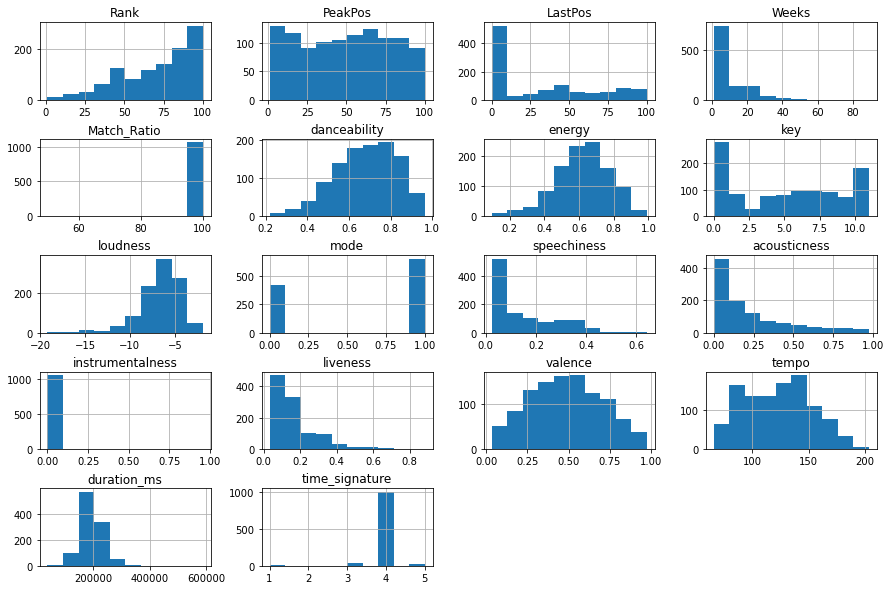

In [19]:
unique_songs.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

### 2.4 Highlighting Risk Areas

In [20]:
#Highlight songs where the match between the Billboard naming and Spotify naming may have pulled the wrong song.
unique_songs[unique_songs.Match_Ratio <= 99].sort_values('Match_Ratio')

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
233,65,2021-06-12,amari,J. Cole,5,41,3,Amarillo,J Balvin,50.0,...,-5.725,0.0,0.3010,0.01300,0.005340,0.0695,0.9610,122.728,157733.0,5.0
239,94,2021-06-12,95.south,J. Cole,8,59,3,Give It To You - 95 South Remix,Jordan Knight,50.0,...,-8.218,0.0,0.1630,0.00839,0.000006,0.1750,0.4220,135.079,312840.0,4.0
245,71,2021-06-05,interlude,J. Cole,8,17,3,worldstar money (interlude),Joji,50.0,...,-8.607,1.0,0.2740,0.96400,0.705000,0.2080,0.4590,146.565,126312.0,1.0
248,80,2021-06-05,100.mil',J. Cole & Bas,14,14,2,"Symphony No. 100 in G Major, Hob. I:100 ""Milit...",Franz Joseph Haydn,50.0,...,-14.561,1.0,0.0340,0.97200,0.568000,0.1780,0.2510,146.746,298516.0,4.0
254,33,2021-05-29,close,J. Cole,33,0,1,Close,Nick Jonas,50.0,...,-5.273,0.0,0.0820,0.25300,0.000000,0.1440,0.4010,123.996,234213.0,4.0
475,39,2021-01-09,Feliz Navidad,Jose Feliciano,6,6,15,Feliz Navidad,José Feliciano,75.0,...,-9.004,1.0,0.0383,0.55000,0.000000,0.3360,0.9630,148.837,182067.0,4.0
447,56,2021-01-23,B.S.,Jhene Aiko Featuring H.E.R.,24,52,23,B.S. (feat. H.E.R.),Jhené Aiko,80.0,...,-10.426,0.0,0.1200,0.55400,0.000001,0.1350,0.3770,135.781,212867.0,4.0
807,70,2020-07-18,P*$$y Fairy (OTW),Jhene Aiko,40,59,25,P*$$Y Fairy (OTW),Jhené Aiko,80.0,...,-7.092,0.0,0.2120,0.53600,0.000000,0.1020,0.3500,128.331,181860.0,4.0
1042,65,2020-03-21,Happiness Over Everything (H.O.E.),Jhene Aiko Featuring Future & Miguel,65,0,1,Happiness Over Everything (H.O.E.) (feat. Futu...,Jhené Aiko,80.0,...,-8.134,0.0,0.3350,0.13100,0.000000,0.2020,0.8670,134.769,188160.0,4.0
1048,87,2020-03-21,Triggered,Jhene Aiko,51,0,4,Triggered (freestyle),Jhené Aiko,80.0,...,-10.765,1.0,0.2980,0.79900,0.000000,0.1460,0.3910,93.175,209933.0,4.0


In [21]:
#Find instances of duplicated song id
unique_songs[unique_songs['SP_id'].isin(unique_songs['SP_id'][unique_songs['SP_id'].duplicated()])\
             & ~unique_songs['SP_id'].isnull()].sort_values("SP_id")

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
546,93,2020-12-19,Life Goes On,BTS,1,28,3,Life Goes On,BTS,100.0,...,-5.733,1.0,0.0424,0.00691,0.000000,0.370,0.450,81.068,207481.0,4.0
1062,68,2020-03-14,ON,BTS,4,4,2,Life Goes On,BTS,100.0,...,-5.733,1.0,0.0424,0.00691,0.000000,0.370,0.450,81.068,207481.0,4.0
901,65,2020-05-23,Zoo York,Lil Tjay Featuring Fivio Foreign & Pop Smoke,65,0,1,Zoo York (feat. Fivio Foreign & Pop Smoke),Lil Tjay,100.0,...,-6.084,0.0,0.3790,0.03520,0.000009,0.106,0.303,92.466,214825.0,5.0
1034,28,2020-03-21,POP,Lil Uzi Vert,28,0,1,Zoo York (feat. Fivio Foreign & Pop Smoke),Lil Tjay,100.0,...,-6.084,0.0,0.3790,0.03520,0.000009,0.106,0.303,92.466,214825.0,5.0
204,82,2021-06-26,Voice Of The Heroes,Lil Baby & Lil Durk,21,21,3,Voice of the Heroes,Lil Baby,100.0,...,-6.811,1.0,0.2670,0.17900,0.000000,0.194,0.316,83.000,209299.0,4.0
713,62,2020-09-19,The Voice,Lil Durk,62,0,1,Voice of the Heroes,Lil Baby,100.0,...,-6.811,1.0,0.2670,0.17900,0.000000,0.194,0.316,83.000,209299.0,4.0
195,98,2021-07-03,How It Feels,Lil Baby & Lil Durk,34,80,3,How It Feels,Lil Baby,100.0,...,-5.746,0.0,0.1200,0.00715,0.000000,0.132,0.479,104.083,166911.0,4.0
1059,59,2020-03-14,How,Lil Baby,59,0,1,How It Feels,Lil Baby,100.0,...,-5.746,0.0,0.1200,0.00715,0.000000,0.132,0.479,104.083,166911.0,4.0
235,83,2021-06-12,Goosebumps,Travis Scott & HVME,47,84,20,goosebumps,Travis Scott,100.0,...,-3.370,1.0,0.0484,0.08470,0.000000,0.149,0.430,130.049,243837.0,4.0
935,49,2020-05-09,Goosebumps,Travis Scott,32,0,35,goosebumps,Travis Scott,100.0,...,-3.370,1.0,0.0484,0.08470,0.000000,0.149,0.430,130.049,243837.0,4.0


### 2.5 Missing Values

In [22]:
unique_songs[unique_songs['SP_id'].isnull()]

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
14,15,2021-08-28,Leave The Door Open,Silk Sonic (Bruno Mars & Anderson .Paak),1,14,24,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,90,2021-08-28,my.life,"J. Cole, 21 Savage & Morray",2,73,14,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,92,2021-07-31,transparentsoul,Willow Featuring Travis Barker,76,93,6,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,88,2021-07-03,pride.is.the.devil,J. Cole & Lil Baby,7,84,6,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,72,2021-06-05,applying.pressure,J. Cole,13,13,2,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,83,2021-06-05,let.go.my.hand,"J. Cole, Bas & 6LACK",19,19,2,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,97,2021-06-05,punchin'.the.clock,J. Cole,20,20,2,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,99,2021-06-05,the.climb.back,J. Cole,25,25,4,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,28,2021-05-29,hunger.on.hillside,J. Cole & Bas,28,0,1,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,85,2021-05-01,Momma's House,Dustin Lynch,59,69,15,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3.0 Summary

Data Used
- Billboard Hot 100 Chart data will be used as reference for a song's success, focusing on Peak Position and Weeks on the Charts
- Spotify song attribute data will be used to analyze the characteristics of these songs for comparison against each other
- Across 78 weeks of Billboard Charts (~18 months), there are 1094 unique songs for consideration in this analysis
- There are 13 song attributes for analysis

Risk Areas
- Using fuzzywuzzy to quantify the match ratio between the Billboard artist/track name and the Spotify artist/track name, 5 songs were paired with the incorrect Spotify_ID
- 21 songs were not found as part of the search process in Spotify
- 5 Song_IDs have duplicates where the same song was found for 2 unique songs in the Billboard chart
- This would result in ~3% of the available songs being disregarded due to song result error

In [23]:
#Export unique song data.

cwd = os.getcwd()
path = cwd + "/new"
unique_songs.to_csv(path)